In [1]:

path = "npatlas/npatlas.json"
import json
with open(path, 'r') as f:
    objs = json.load(f)
    
len(objs)

36454

In [2]:
assert all("smiles" in obj for obj in objs)

In [3]:
distinct_structures = set(obj["smiles"] for obj in objs)

In [4]:
len(distinct_structures)

36434

In [66]:
import re
from copy import copy


def flatten_entry(entry: dict):
    flattened = copy(entry)
    #flattened["classyfire_class_name"] = entry["classyfire"]["class"]["name"]
    cf = entry.get("classyfire", {})
    if cf:
        cf_class = cf.get("class", {})
        if cf_class:
            flattened["classyfire_class_name"] = cf_class.get("name")
        cf_subclass = cf.get("subclass", {})
        if cf_subclass:
            flattened["classyfire_subclass_name"] = cf_subclass.get("name")
        cf_superclass = cf.get("superclass", {})
        if cf_superclass:
            flattened["classyfire_superclass_name"] = cf_superclass.get("name")
        chebi_terms = cf.get("predicted_chebi_terms", [])
        entry["chebi_terms_flat"] = "; ".join(chebi_terms)
        chebi_term_ix = {}
        for t in chebi_terms:
            for k, v in re.findall(r"(.*) \((CHEBI:\d+)\)", t):
                chebi_term_ix[k] = v
        entry["predicted_chebi_index"] = chebi_term_ix
        entry["predicted_chebi_ids"] = tuple(chebi_term_ix.keys())
        entry["predicted_chebi_labels"] = tuple(chebi_term_ix.values())
        lipidmaps_terms = cf.get("predicted_lipidmaps_terms", [])
        entry["lipidmaps_terms_flat"] = "; ".join(lipidmaps_terms)
        lipidmaps_term_ix = {}
        for t in lipidmaps_terms:
            for k, v in re.findall(r"(.*) \((FA\d+)\)", t):
                lipidmaps_term_ix[k] = v
        entry["predicted_lipidmaps_index"] = lipidmaps_term_ix
        entry["predicted_lipidmaps_ids"] = tuple(lipidmaps_term_ix.keys())
        entry["predicted_lipidmaps_labels"] = tuple(lipidmaps_term_ix.values())
        
    formula = entry.get("mol_formula")
    # split formula string, e.g. "C10H12O5" -> {"C": 10, "H": 12, "O": 5}
    if formula:
        flattened.update({k: int(v) for k, v in re.findall(r"([A-Z][a-z]*)(\d+)", formula)})
    oref = entry.get("origin_reference", {})
    flattened["doi"] = oref.get("doi")
    flattened["pmid"] = oref.get("pmid")
    
    return flattened
    
flattened_entries = [flatten_entry(obj) for obj in objs]

In [67]:
entries_no_cf = [e for e in flattened_entries if "classyfire_class_name" not in e or not e["classyfire_class_name"]]
len(entries_no_cf)

793

In [68]:
len([e for e in flattened_entries if "classyfire_subclass_name" not in e or not e["classyfire_subclass_name"]])

7264

In [69]:
import pandas as pd
entries_df = pd.DataFrame(flattened_entries)
entries_df

,id,npaid,original_name,mol_formula,mol_weight,exact_mass,inchikey,smiles,cluster_id,node_id,...,doi,pmid,N,S,Cl,Br,I,P,Se,Fe
0,1,NPA000001,Curvularide C,C19H37NO5,359.5070,359.2672,BZLIDAVUQDTJQF-HWTFSWDCSA-N,CC[C@H](C)[C@@H](CO)NC(=O)/C=C/[C@](C)([C@H]([...,1,1,...,10.1002/chem.201000652,20680940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NPA000002,Homopetasinic acid,C24H32O6,416.5140,416.2199,MMWCHIIGAIJQMV-DHCANEKFSA-N,C[C@H]1[C@@H](CCC2=CC(=O)[C@@H](C[C@]12C)C(=C)...,2,2,...,10.1016/j.tetlet.2016.01.095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NPA000003,A-503083 F,C18H22N4O13,502.3890,502.1183,RNRCUOCMUNIOMZ-UHFFFAOYSA-N,COC1C(C(OC1C(C(=O)N)OC2C(C(C=C(O2)C(=O)O)O)O)N...,3,3,...,10.7164/antibiotics.57.639,15638324.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NPA000004,Aqabamycin E2,C16H11N3O5,325.2800,325.0699,NMMDNCZQLOFGES-UHFFFAOYSA-N,C1=CC=C(C=C1)C2=C(NC(=C2C3=CC(=C(C=C3)O)[N+](=...,4,4,...,10.1038/ja.2010.34,20431617.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NPA000005,Hymenopsin A,C22H32O6,392.4920,392.2199,OYLVOLOSQHRPLK-WRXMSMRBSA-N,C[C@]1(CCC[C@]2([C@H]1CC=C3[C@@H]2C[C@]45C(O4)...,5,5,...,10.1021/np900613d,19928955.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,36718,NPA036718,Julichrome Q3-3,C38H38O16,750.7060,750.2160,FCANTWZHYAQEKU-DLUJSSSPSA-N,CC(=O)O[C@H](C)[C@H]1[C@@](C)(O)CC(=O)[C@]23O[...,1472,1213,...,10.1021/ja501630w,24746278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36450,36719,NPA036719,GE81112A,C24H34ClN9O10,644.0420,643.2117,MPRVLYUMDIXCGD-UHFFFAOYSA-N,NC(=O)OCC(O)CC(NC(=O)C1NCCCC1O)C(=O)NC(CC1=CN=...,2001,1606,...,10.1021/bi052540k,16533052.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36451,36723,NPA036723,Subvellerolactone C,C17H26O5,310.3900,310.1780,KJKLEJNFKHFYGR-PDROMXSDSA-N,CC[C@]1(O)OC(=O)C2=C1[C@H](O)[C@@H]1CC(C)(C)C[...,10508,28,...,10.5281/zenodo.13381755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36452,36726,NPA036726,10E-cyclonerotriol,C15H28O3,256.3860,256.2038,QGUPPGVBDCWDSK-BSYVWGKESA-N,C/C(=C\CC[C@@](C)(O)[C@@H]1CC[C@@](C)(O)[C@H]1...,79,74,...,10.1039/p19750001586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
entries_df[entries_df["chebi_terms_flat"] == ""]

,id,npaid,original_name,mol_formula,mol_weight,exact_mass,inchikey,smiles,cluster_id,node_id,...,doi,pmid,N,S,Cl,Br,I,P,Se,Fe
11520,11662,NPA011662,Cupressolide B,C15H24O3,252.3540,252.1725,DFHRWBZCTUSIET-BBZRCZKMSA-N,C[C@H]1CC[C@@H]2[C@]3([C@@]1(C[C@H]([C@@H](C3)...,4484,28,...,10.1590/s0103-50532010000800006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27343,27605,NPA027605,Chlorophyll F,C55H70MgN4O6,907.4920,906.5146,KBRADYZADSYWEL-UCLIUJATSA-L,C=CC1=C2C=C3N=C(C=C4[N-]C5=C(C6=NC(=CC(=N2)C1=...,8280,2154,...,10.1126/science.1191127,20724585.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27365,27627,NPA027627,12β-deoxygonyautoxin 3,C10H18N7O7S+,380.3630,380.0983,CMLIMTOXQQYXEA-WMTVMBERSA-O,NC(=O)OC[C@@H]1NC(N)=[N+]2C[C@H](OS(=O)(=O)O)[...,8282,5630,...,10.3390/toxins11090539,31527551.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28233,28496,NPA028496,Ferroverdin,C45H33FeN3O12+2,863.6130,863.1403,MDOZWQQLJFPFCI-UHFFFAOYSA-N,C=CC1=CC=C(OC(=O)C2=CC(N=O)=C(O)C=C2)C=C1.C=CC...,1847,1491,...,10.1038/224589a0,5346597.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28345,28609,NPA028609,Aeronamide A,C195H330N50O58,4303.0770,4300.4410,DRJALLWOIJKMJI-OXLRMDFFSA-N,CCC(=O)C(=O)N[C@H](C(=O)N[C@H](C)C(=O)N[C@H](C...,8550,5785,...,10.1038/s41557-019-0323-9,31501509.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36316,36584,NPA036584,5R-hydroxysecopatulolide C,C12H22O5,246.3030,246.1467,LENPVQIMQYFFKV-QMVIJHPZSA-N,C[C@@H](O)CCCCC[C@@H](O)[C@H](O)/C=C/C(=O)O,151,143,...,10.1002/cbdv.202200963,36436828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36317,36585,NPA036585,11-O-acetylsecopatulolide C,C14H24O5,272.3410,272.1624,VNQHJGUUCHEORV-FCSPZMLESA-N,CC(=O)O[C@H](C)CCCCCC[C@H](O)/C=C/C(=O)O,151,143,...,10.1002/cbdv.202200963,36436828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36318,36586,NPA036586,11-O-acetyl-5R-hydroxysecopatulolide C.,C14H24O6,288.3400,288.1573,FEMQOCTYPCWQMH-XBSVOTOGSA-N,CC(=O)O[C@H](C)CCCCC[C@@H](O)[C@H](O)/C=C/C(=O)O,151,143,...,10.1002/cbdv.202200963,36436828.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36319,36587,NPA036587,Mycochromone A,C15H16O6,292.2870,292.0947,PLTUBDXCCJAXFC-UFTIBIJLSA-N,C[C@H]1CC(=O)O[C@@H]1[C@]1(CO)CC(=O)C2=C(O)C=C...,66,62,...,10.1002/cbdv.202200998,36318651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
entries_df[entries_df["lipidmaps_terms_flat"] != ""]


,id,npaid,original_name,mol_formula,mol_weight,exact_mass,inchikey,smiles,cluster_id,node_id,...,doi,pmid,N,S,Cl,Br,I,P,Se,Fe
0,1,NPA000001,Curvularide C,C19H37NO5,359.5070,359.2672,BZLIDAVUQDTJQF-HWTFSWDCSA-N,CC[C@H](C)[C@@H](CO)NC(=O)/C=C/[C@](C)([C@H]([...,1,1,...,10.1002/chem.201000652,20680940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NPA000002,Homopetasinic acid,C24H32O6,416.5140,416.2199,MMWCHIIGAIJQMV-DHCANEKFSA-N,C[C@H]1[C@@H](CCC2=CC(=O)[C@@H](C[C@]12C)C(=C)...,2,2,...,10.1016/j.tetlet.2016.01.095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NPA000005,Hymenopsin A,C22H32O6,392.4920,392.2199,OYLVOLOSQHRPLK-WRXMSMRBSA-N,C[C@]1(CCC[C@]2([C@H]1CC=C3[C@@H]2C[C@]45C(O4)...,5,5,...,10.1021/np900613d,19928955.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NPA000007,Chaetoxanthone A,C20H18O7,370.3570,370.1053,PYEDKAHYOPGAKC-PDXJJUDESA-N,C[C@]12C[C@@H](C[C@H](O1)C3=C(O2)C=C4C(=C3O)C(...,7,7,...,10.1021/np800294q,18683985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NPA000008,Dihydroxydione 13,C23H35NO4S,421.6030,421.2287,MAZMBUSHGWINCC-RHTYRPEXSA-N,CCC(=O)[C@H](C)[C@H]([C@@H](C)C(=O)CC/C(=C\CC(...,8,8,...,10.1021/np030218+,14575429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36449,36718,NPA036718,Julichrome Q3-3,C38H38O16,750.7060,750.2160,FCANTWZHYAQEKU-DLUJSSSPSA-N,CC(=O)O[C@H](C)[C@H]1[C@@](C)(O)CC(=O)[C@]23O[...,1472,1213,...,10.1021/ja501630w,24746278.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36450,36719,NPA036719,GE81112A,C24H34ClN9O10,644.0420,643.2117,MPRVLYUMDIXCGD-UHFFFAOYSA-N,NC(=O)OCC(O)CC(NC(=O)C1NCCCC1O)C(=O)NC(CC1=CN=...,2001,1606,...,10.1021/bi052540k,16533052.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36451,36723,NPA036723,Subvellerolactone C,C17H26O5,310.3900,310.1780,KJKLEJNFKHFYGR-PDROMXSDSA-N,CC[C@]1(O)OC(=O)C2=C1[C@H](O)[C@@H]1CC(C)(C)C[...,10508,28,...,10.5281/zenodo.13381755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36452,36726,NPA036726,10E-cyclonerotriol,C15H28O3,256.3860,256.2038,QGUPPGVBDCWDSK-BSYVWGKESA-N,C/C(=C\CC[C@@](C)(O)[C@@H]1CC[C@@](C)(O)[C@H]1...,79,74,...,10.1039/p19750001586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
entries_df[["C", "classyfire_class_name",  "classyfire_subclass_name", "chebi_terms_flat"]].value_counts()

C      classyfire_class_name             classyfire_subclass_name              chebi_terms_flat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
15.0   Prenol lipids                     Sesquiterpenoids                                                                                                                                    

In [73]:
entries_df[["C", "classyfire_class_name",  "classyfire_subclass_name", "chebi_terms_flat", "lipidmaps_terms_flat"]].value_counts()


C      classyfire_class_name             classyfire_subclass_name                  chebi_terms_flat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [37]:
entries_df[["C", "classyfire_class_name",  "classyfire_subclass_name"]].value_counts()

C      classyfire_class_name             classyfire_subclass_name            
15.0   Prenol lipids                     Sesquiterpenoids                        868
30.0   Prenol lipids                     Triterpenoids                           366
20.0   Prenol lipids                     Diterpenoids                            186
15.0   Organooxygen compounds            Alcohols and polyols                    159
16.0   Benzopyrans                       1-benzopyrans                           156
                                                                                ... 
22.0   Pyridines and derivatives         Bipyridines and oligopyridines            1
       Pteridines and derivatives        Alloxazines and isoalloxazines            1
       Phenols                           Cresols                                   1
                                         1-hydroxy-4-unsubstituted benzenoids      1
201.0  Carboxylic acids and derivatives  Amino acids, peptides, and anal

In [52]:
entries_df[(entries_df["C"] > 20) & (entries_df["classyfire_subclass_name"] == "Sesquiterpenoids")][["C", "classyfire_class_name",  "classyfire_subclass_name"]].value_counts()

C     classyfire_class_name  classyfire_subclass_name
21.0  Prenol lipids          Sesquiterpenoids            85
23.0  Prenol lipids          Sesquiterpenoids            85
25.0  Prenol lipids          Sesquiterpenoids            75
22.0  Prenol lipids          Sesquiterpenoids            67
29.0  Prenol lipids          Sesquiterpenoids            66
24.0  Prenol lipids          Sesquiterpenoids            52
26.0  Prenol lipids          Sesquiterpenoids            51
27.0  Prenol lipids          Sesquiterpenoids            43
28.0  Prenol lipids          Sesquiterpenoids            41
30.0  Prenol lipids          Sesquiterpenoids            41
31.0  Prenol lipids          Sesquiterpenoids            21
33.0  Prenol lipids          Sesquiterpenoids            16
32.0  Prenol lipids          Sesquiterpenoids            15
39.0  Prenol lipids          Sesquiterpenoids             7
37.0  Prenol lipids          Sesquiterpenoids             5
34.0  Prenol lipids          Sesquiterpenoids 

In [53]:
entries_df[(entries_df["C"] >= 40) & (entries_df["doi"].notna()) & (entries_df["classyfire_subclass_name"] == "Sesquiterpenoids")][["C", "classyfire_subclass_name", "doi", "pmid", "original_name", "smiles"]]


,C,classyfire_subclass_name,doi,pmid,original_name,smiles
3864,43.0,Sesquiterpenoids,10.1016/j.tet.2008.11.078,NaN,Meleagrin B,C[C@@H]1[C@@H](C[C@@]2([C@]3([C@]14C[C@@]5(CCC...
7697,44.0,Sesquiterpenoids,10.1021/np300751m,23305465.0,Albatrelin D,CC1=CC(=C(C2=C1C3=C(C(=C4C(=C3O2)C=C[C@@](O4)(...
7708,40.0,Sesquiterpenoids,10.1021/acs.orglett.5b01353,26024438.0,Cochlearoid A,CC(=CCC/C(=C/CC/C(=C/CC1=C2C(=CC(=C1)O)C3=C(C=...
11690,45.0,Sesquiterpenoids,10.1021/acs.orglett.5b01356,26068271.0,Sterhirsutin I,C=C1C(=O)C(OC(=O)[C@@]2(C)C[C@@H]3CC4=C(OC(=O)...
18411,46.0,Sesquiterpenoids,10.1021/acs.orglett.5b01356,26068271.0,Sterhirsutin H,C=C1C(=O)C(OC(=O)[C@@]2(C)C[C@@H]3CC4=C(OC(=O)...
32821,40.0,Sesquiterpenoids,10.1002/chem.202104484,NaN,Sandacrabin C,CC(C)=CCC/C(C)=C/CC/C(C)=C/CN1C(C)=[N+](C/C=C(...
35303,53.0,Sesquiterpenoids,10.1055/a-1392-1038,33682913.0,Talatrachyoxazine B,C=C(C)[C@@H]1CC[C@@H](C)[C@@]2(O)[C@@H]1C=C(C)...
35304,53.0,Sesquiterpenoids,10.1055/a-1392-1038,33682913.0,Talatrachyoxazine C,C=C(C)[C@@H]1CC[C@@H](C)[C@@]2(O)[C@@H]1C=C(C)...
35941,42.0,Sesquiterpenoids,10.3390/md19020098,NaN,Dinotoamide J,C=CC(C)(C)C1(C[C@@H]2NC(=O)[C@@H]3CCCN3C2=O)C(...


## C3P Classification

In [74]:
from c3p.classifier import Classifier

c3p_classifier = Classifier()

In [75]:
!mkdir -p npatlas

In [76]:
def classify_all(classifier, structures):
    n = 0
    results = []
    for r in classifier.classify_iter(structures):
        if r.is_match:
            results.append(r)
            n += 1
            if n % 1000 == 0:
                print(n)
       
    print(len(results))
    return results
    

        

In [77]:
c3p_df

,Unnamed: 0,input_smiles,class_id,class_name,is_match,reason,confidence
0,0,CC(C)CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(COP(=O)...,CHEBI:17517,phosphatidylglycerol,True,Contains glycerol backbone with 2 fatty acid c...,0.913408
1,1,CC(=O)OCCCCC/C=C\C[C@@]\1(C=CC(=O)/C1=C/C=C\[C...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
2,2,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C/C=C/CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
3,3,C[C@H](CC1=C([C@@]([C@@H](C1=O)NC(=O)CO)(C(=O)...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
4,4,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C\C=C\CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000
...,...,...,...,...,...,...,...
146878,146878,CC1=C(C2=C(C(=C1Cl)O)C(=O)C3=C(O2)C=C(C=C3C(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146879,146879,CC1=CC(=CC2=C1C3=CC(=CC(=C3C(=O)O2)O)OS(=O)(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146880,146880,CC(=CCC1=CC(=C2C(=C1O)C(=O)C3=CC(=CC(=C3O2)O)O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749
146881,146881,CC1=C(C=C2C(=C1)OC3=C(C=C(C(=C3C2=O)C)C4=CC(=C...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749


In [78]:
from pathlib import Path
import pandas as pd


path = Path("npatlas/c3p_results.csv")
if path.exists():
    c3p_df = pd.read_csv(path)
else:
    c3p_results = classify_all(c3p_classifier, distinct_structures)
    c3p_df = pd.DataFrame( [r.model_dump() for r in c3p_results] )
    c3p_df.to_csv(path)



In [79]:
c3p_df["class_name"].value_counts()

class_name
diterpenoid                            18926
diol                                    8724
phenylpropanoid                         8711
icosanoid                               8411
semisynthetic derivative                5531
                                       ...  
straight-chain saturated fatty acid        1
tetrachlorobenzene                         1
polyprenol phosphate                       1
aliphatic aldoxime                         1
phosphatidylglycerol                       1
Name: count, Length: 269, dtype: int64

## CHEBI classification

In [80]:
from pathlib import Path
import pandas as pd


path = Path("npatlas/chebi_results.csv")
if path.exists():
    chebi_df = pd.read_csv(path)
else:
    from c3p.chebi_classifier import ChEBIClassifier
    chebi_classifier = ChEBIClassifier()
    chebi_results = classify_all(chebi_classifier, distinct_structures)
    chebi_df = pd.DataFrame( [r.model_dump() for r in chebi_results] )
    chebi_df.to_csv(path)

185103

In [16]:
#chebi_results = classify_all(chebi_classifier, list(distinct_structures))

1000
1527


In [17]:
#len(chebi_results)

1527

In [19]:
from c3p.clients.chebifier import ChebifierClient

chebifier = ChebifierClient()
chebifier_results = {}


In [23]:
for s in distinct_structures:
    if s not in chebifier_results:
        chebifier_results[s] = chebifier.classify(s)

HTTPError: 502 Server Error: Bad Gateway for url: https://chebifier.hastingslab.org/api/classify

In [22]:
len(chebifier_results) / len(distinct_structures)

0.7312400505022781

In [32]:
list(chebifier_results.values())[0]

[ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:25806', class_name='oxygen molecular entity', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:33308', class_name='carboxylic ester', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:25367', class_name='molecule', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[C@]3(CC[C@@H]4[C@]5(CC[C@@H](C([C@@H]5CC[C@]4([C@@H]3C2)C)(C)C)OC(=O)C)C)C', class_id='CHEBI:24532', class_name='organic heterocyclic compound', is_match=True, reason=None, confidence=1.0),
 ClassificationResult(input_smiles='CC1=CC(=O)C2=C(O1)O[

In [33]:
chebifier_df = pd.DataFrame( [r.model_dump() for rs in chebifier_results.values() for r in rs] )

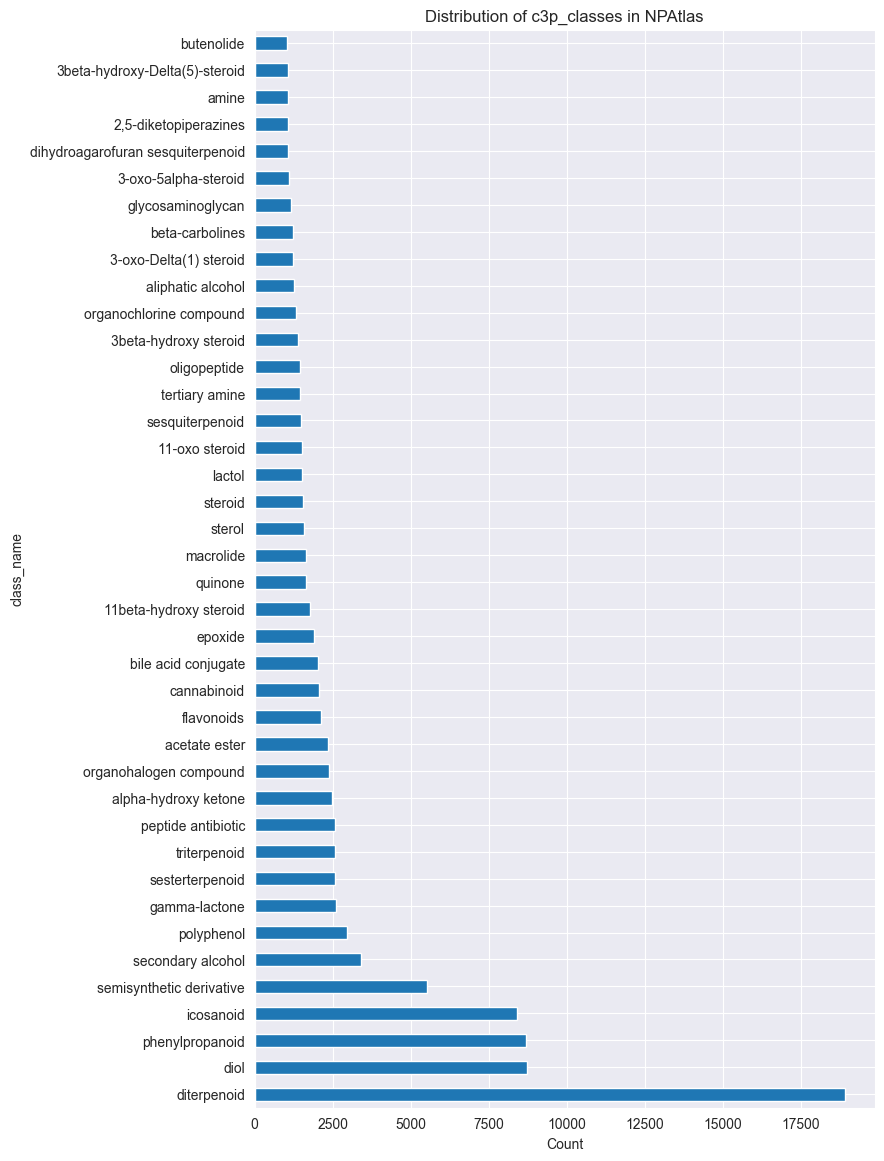

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(df, column_name="class_name", title=None, min_count=1000):
    
    # Count occurrences of each class
    class_counts = df[column_name].value_counts()
    # filter to be at least N
    class_counts = class_counts[class_counts > min_count]
    
    # Re-plot the bar chart with c3p_classes on y-axis (horizontal bar chart)
    plt.figure(figsize=(8, 14))
    class_counts.plot(kind='barh')
    plt.ylabel(column_name)
    plt.xlabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(c3p_df, column_name="class_name", title="Distribution of c3p_classes in NPAtlas")

In [17]:
plot_class_distribution(chebifier_df, column_name="class_name", title="Distribution of chebifier_classes in NPAtlas")


NameError: name 'chebifier_df' is not defined

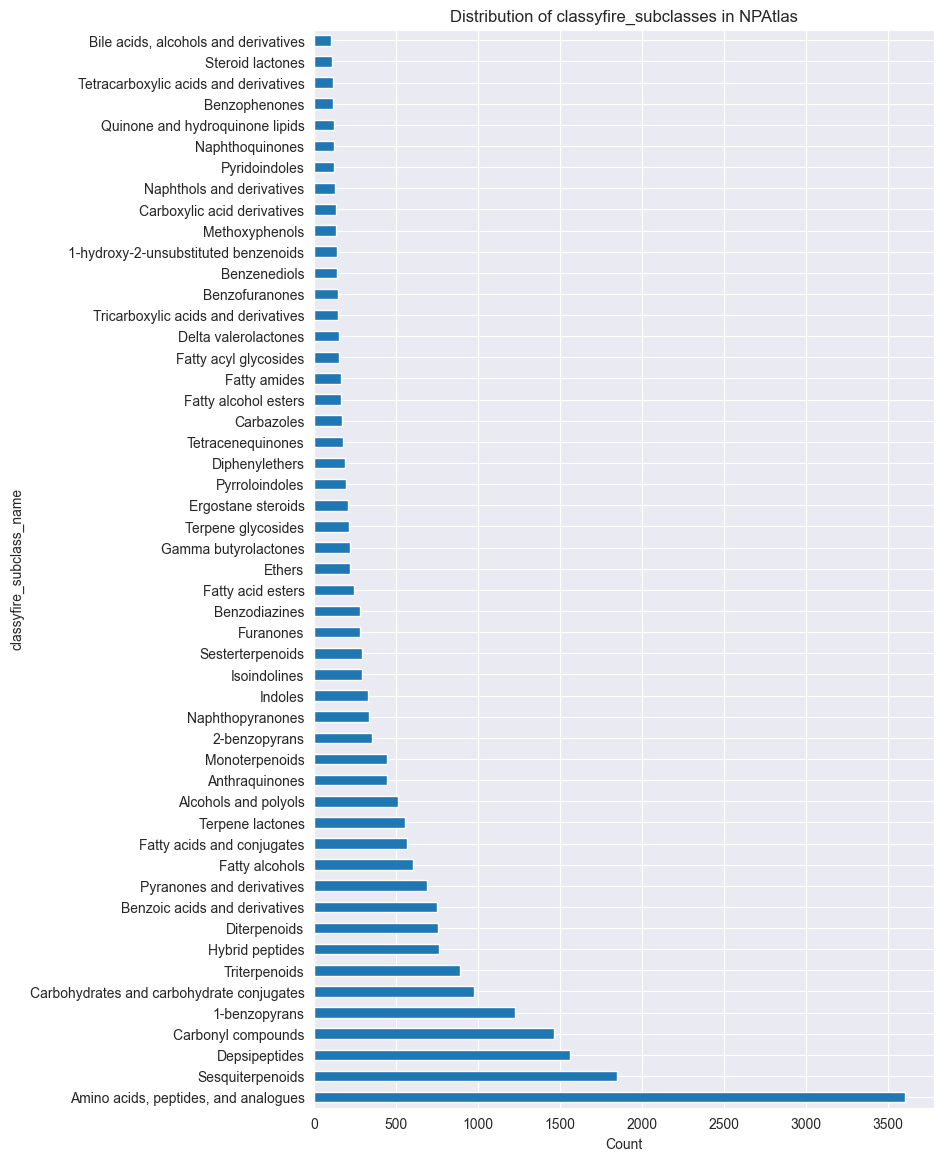

In [86]:
plot_class_distribution(entries_df, column_name="classyfire_subclass_name", title="Distribution of classyfire_subclasses in NPAtlas", min_count=100)


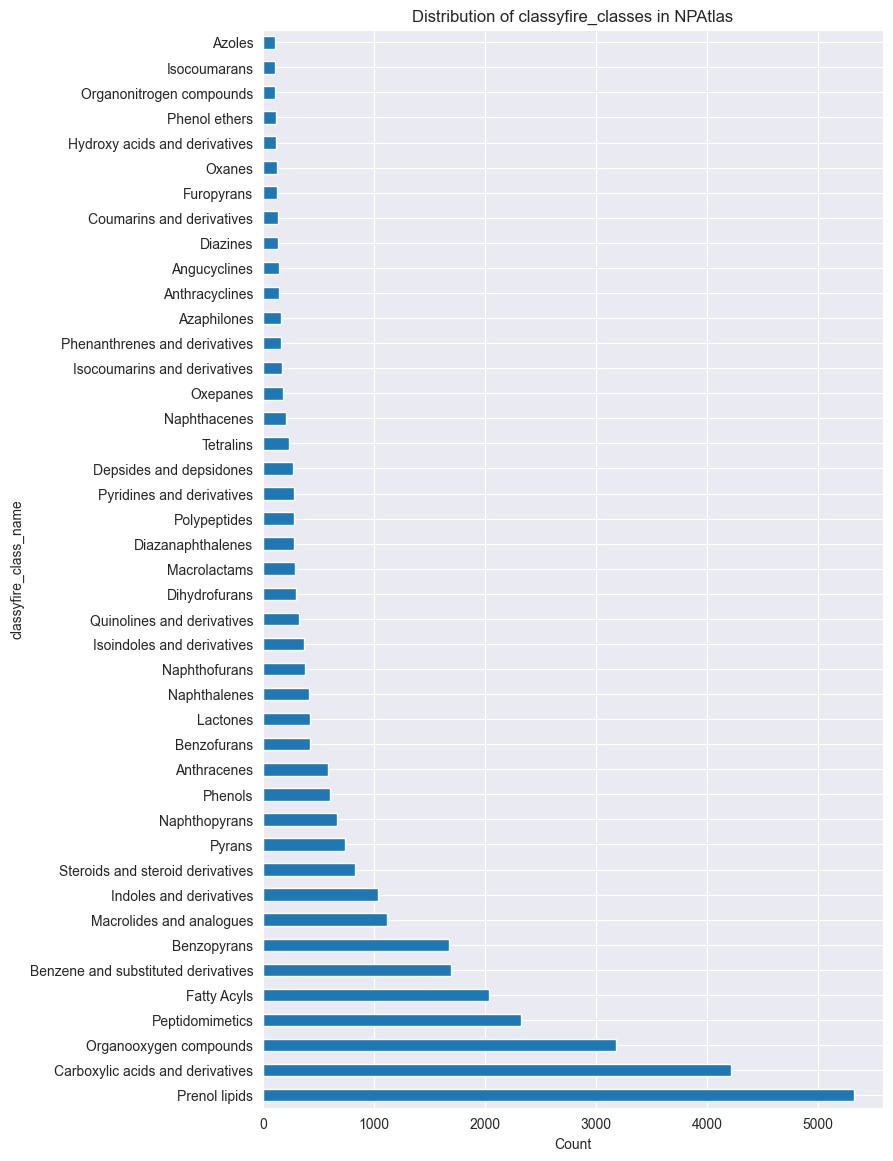

In [87]:
plot_class_distribution(entries_df, column_name="classyfire_class_name", title="Distribution of classyfire_classes in NPAtlas", min_count=100)

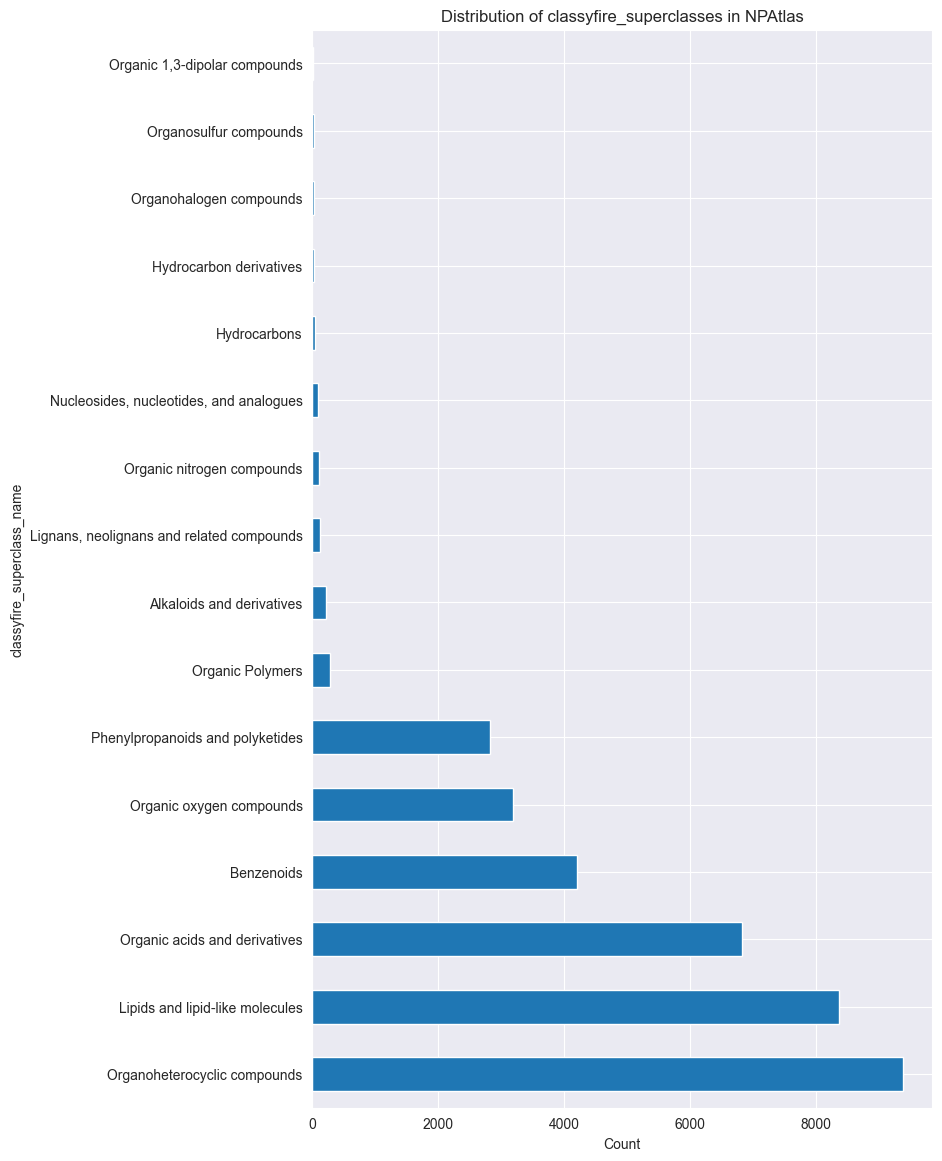

In [88]:
plot_class_distribution(entries_df, column_name="classyfire_superclass_name", title="Distribution of classyfire_superclasses in NPAtlas", min_count=5)


In [89]:
def merge_classifications_df(entries_df, df, renamed_column="c3p_class_name"):
    df2 = df.rename(columns={"class_name": renamed_column})
    joined = df2.merge(entries_df, left_on="input_smiles", right_on="smiles")
    # compare the two columns
    return joined


merged_df = merge_classifications_df(entries_df, c3p_df)
merged_df
    

,Unnamed: 0,input_smiles,class_id,c3p_class_name,is_match,reason,confidence,id,npaid,original_name,...,doi,pmid,N,S,Cl,Br,I,P,Se,Fe
0,0,CC(C)CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(COP(=O)...,CHEBI:17517,phosphatidylglycerol,True,Contains glycerol backbone with 2 fatty acid c...,0.913408,825,NPA000825,DPG,...,10.1021/np990313b,10843572.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,1,CC(=O)OCCCCC/C=C\C[C@@]\1(C=CC(=O)/C1=C/C=C\[C...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,14701,NPA014701,Not named,...,10.1016/s0040-4039(00)85917-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C/C=C/CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,5289,NPA005289,Chlorovulone II,...,10.1016/s0040-4039(00)98927-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,C[C@H](CC1=C([C@@]([C@@H](C1=O)NC(=O)CO)(C(=O)...,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,24358,NPA024358,Mccrearamycin D,...,10.1002/anie.201612447,28140487.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CCCCC/C=C\CC\1(C=C(C(=O)/C1=C\C=C\CCCC(=O)OC)Cl)O,CHEBI:36092,clavulone,True,Contains characteristic clavulone structural f...,0.750000,15407,NPA015407,Chlorovulone III,...,10.1016/s0040-4039(00)98927-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146946,146878,CC1=C(C2=C(C(=C1Cl)O)C(=O)C3=C(O2)C=C(C=C3C(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,8373,NPA008373,Penicillixanthone,...,10.1016/j.tet.2014.05.105,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
146947,146879,CC1=CC(=CC2=C1C3=CC(=CC(=C3C(=O)O2)O)OS(=O)(=O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,7981,NPA007981,Alternariol 5-O-sulfate,...,10.1021/np070447m,18494522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146948,146880,CC(=CCC1=CC(=C2C(=C1O)C(=O)C3=CC(=CC(=C3O2)O)O...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,8026,NPA008026,Umbilicaxanthoside A,...,10.1016/s0031-9422(02)00539-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146949,146881,CC1=C(C=C2C(=C1)OC3=C(C=C(C(=C3C2=O)C)C4=CC(=C...,CHEBI:50753,isoflavonoid,True,Molecule contains a fused benzopyran core (6-m...,0.278749,21472,NPA021472,Verrulactone D,...,10.1038/ja.2015.86,26306815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
merged_df[["classyfire_subclass_name", "c3p_class_name"]].value_counts()


classyfire_subclass_name              c3p_class_name       
Amino acids, peptides, and analogues  diterpenoid              1506
Sesquiterpenoids                      diterpenoid              1365
Amino acids, peptides, and analogues  icosanoid                1265
Depsipeptides                         peptide antibiotic       1216
Amino acids, peptides, and analogues  phenylpropanoid           922
                                                               ... 
Benzoisochromanequinones              tertiary amine oxide        1
Benzophenones                         11-oxo steroid              1
                                      2,5-diketopiperazines       1
Fatty acid esters                     organic sulfide             1
Amines                                aralkylamine                1
Name: count, Length: 7044, dtype: int64

In [91]:
merged_df[["classyfire_class_name", "c3p_class_name"]].value_counts()

classyfire_class_name             c3p_class_name                
Prenol lipids                     diterpenoid                       4180
Carboxylic acids and derivatives  diterpenoid                       1827
Organooxygen compounds            diterpenoid                       1688
Peptidomimetics                   peptide antibiotic                1634
Prenol lipids                     icosanoid                         1605
                                                                    ... 
Macrolides and analogues          alpha-amino acid                     1
                                  2-oxo monocarboxylic acid            1
Macrolide lactams                 secondary alpha-hydroxy ketone       1
                                  acetate ester                        1
Vinylogous esters                 sesquiterpenoid                      1
Name: count, Length: 5166, dtype: int64

In [92]:
merged_df[["classyfire_superclass_name", "classyfire_class_name", "classyfire_subclass_name", "c3p_class_name"]].value_counts()


classyfire_superclass_name       classyfire_class_name             classyfire_subclass_name                    c3p_class_name        
Organic acids and derivatives    Carboxylic acids and derivatives  Amino acids, peptides, and analogues        diterpenoid               1506
Lipids and lipid-like molecules  Prenol lipids                     Sesquiterpenoids                            diterpenoid               1365
Organic acids and derivatives    Carboxylic acids and derivatives  Amino acids, peptides, and analogues        icosanoid                 1265
                                 Peptidomimetics                   Depsipeptides                               peptide antibiotic        1216
                                 Carboxylic acids and derivatives  Amino acids, peptides, and analogues        phenylpropanoid            922
                                                                                                                                         ... 
Organoheterocy

In [93]:
def make_correlation_df(df, column1, column2):
    return merged_df[[column1, column2]].value_counts().reset_index(name="count")

correlation_df = make_correlation_df(merged_df, "classyfire_class_name", "c3p_class_name")
correlation_df
## correlation_df = merged_df.DataFrame([(cls1, cls2) for cls1, cls2 in class_c3p_mapping.items() for c3p in c3p_list], columns=["classes", "c3p_classes"])

,classyfire_class_name,c3p_class_name,count
0,Prenol lipids,diterpenoid,4180
1,Carboxylic acids and derivatives,diterpenoid,1827
2,Organooxygen compounds,diterpenoid,1688
3,Peptidomimetics,peptide antibiotic,1634
4,Prenol lipids,icosanoid,1605
...,...,...,...
5161,Macrolides and analogues,alpha-amino acid,1
5162,Macrolides and analogues,2-oxo monocarboxylic acid,1
5163,Macrolide lactams,secondary alpha-hydroxy ketone,1
5164,Macrolide lactams,acetate ester,1


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

def plot_correlation(df, col1, col2, N=20, M=20, mode='resid', title=None):
    """
    Plots a heatmap for top N categories in col1 vs top M categories in col2,
    allowing different cell-level statistics:
      - 'count': raw observed counts (default)
      - 'contri': cell-wise chi-square contribution
      - 'resid': standardized residuals

    Args:
        df (pd.DataFrame): The input DataFrame.
        col1 (str): Column name for x-axis (rows).
        col2 (str): Column name for y-axis (columns).
        N (int): Number of top categories to keep from col1.
        M (int): Number of top categories to keep from col2.
        mode (str): Which metric to display in heatmap cells:
                    'count', 'contri', or 'resid'.
        title (str): Optional plot title.
    """

    # 1. Identify top N categories in col1
    top_n_categories_col1 = df[col1].value_counts().nlargest(N).index
    # 2. Identify top M categories in col2
    top_m_categories_col2 = df[col2].value_counts().nlargest(M).index
    
    # 3. Filter the DataFrame
    df_filtered = df[
        df[col1].isin(top_n_categories_col1) &
        df[col2].isin(top_m_categories_col2)
    ]
    
    # 4. Create a contingency table
    contingency_table = pd.crosstab(df_filtered[col1], df_filtered[col2])
    
    # 5. Perform the chi-squared test once
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Overall chi2 = {chi2:.4f}, p-value = {p:.4e}, dof = {dof}")

    # 6. Decide which cell-level statistic to plot
    if mode == 'count':
        # Raw observed counts
        data_to_plot = contingency_table
        fmt_str = 'd'
        colorbar_label = 'Observed Count'
    elif mode == 'contri':
        # Cell-level chi-square contribution: (O-E)^2 / E
        contrib = (contingency_table - expected) ** 2 / expected
        data_to_plot = pd.DataFrame(contrib, 
                                    index=contingency_table.index,
                                    columns=contingency_table.columns)
        fmt_str = '.2f'
        colorbar_label = 'Chi-square Contribution'
    elif mode == 'resid':
        # Standardized residual: (O-E)/sqrt(E)
        resid = (contingency_table - expected) / np.sqrt(expected)
        data_to_plot = pd.DataFrame(resid, 
                                    index=contingency_table.index,
                                    columns=contingency_table.columns)
        fmt_str = '.1f'
        colorbar_label = 'Standardized Residual'
    else:
        raise ValueError("Invalid mode. Choose from ['count', 'contri', 'resid'].")

    # 7. Plot the heatmap
    plt.figure(figsize=(10, 8))
    # Center=0 is often useful for 'contri' or 'resid' to visually highlight +/- deviance
    center_val = 0 if mode in ('contri', 'resid') else None

    sns.heatmap(
        data_to_plot, 
        annot=True, 
        fmt=fmt_str, 
        cmap='coolwarm' if mode in ('contri','resid') else 'YlGnBu',
        center=center_val
    )

    #plt.figure(figsize=(16, 16))
    plt.title(title if title else f"Top {N} {col1} x Top {M} {col2} [{mode}]")
    plt.xlabel(col2)
    plt.ylabel(col1)
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label(colorbar_label)
    
    plt.tight_layout()
    plt.show()
    return data_to_plot, 
    


Overall chi2 = 55174.7285, p-value = 0.0000e+00, dof = 361


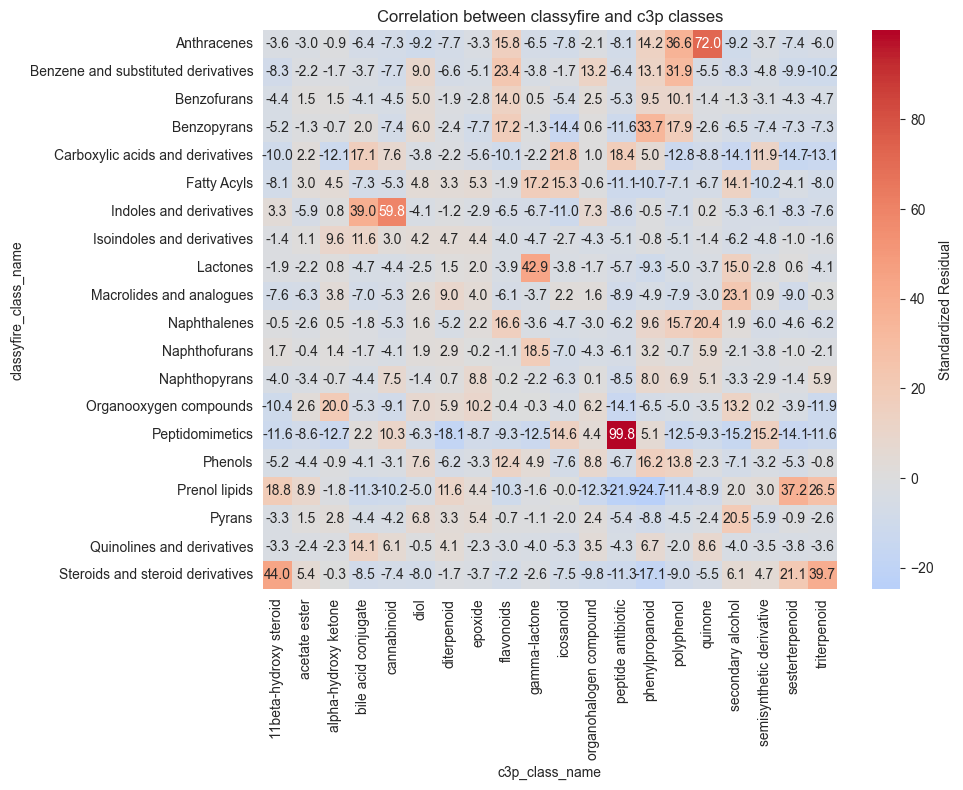

In [95]:
corrs = plot_correlation(merged_df, "classyfire_class_name", "c3p_class_name", title="Correlation between classyfire and c3p classes")

In [96]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def top_significant_pairs(df, col1, col2, N=20, M=20, top_k=20):
    """
    Return a DataFrame of the most positively significant (over-represented) 
    category pairs, based on standardized residuals from the chi-square test.
    
    1. Filter to top N categories in col1 and top M categories in col2 by frequency.
    2. Build contingency table.
    3. Perform chi2_contingency to get expected counts.
    4. Compute standardized residuals = (O - E) / sqrt(E).
    5. Return a table of pairs sorted by descending standardized residual.
    
    Args:
        df (pd.DataFrame): input data
        col1 (str): the name of the first categorical column
        col2 (str): the name of the second categorical column
        N (int): keep top N categories in col1
        M (int): keep top M categories in col2
        top_k (int): how many top pairs to return (sorted by largest positive standardized residual)
        
    Returns:
        pd.DataFrame: A DataFrame with columns:
                      [col1, col2, observed_count, expected_count, std_resid]
    """
    
    # 1. Identify top N categories in col1
    top_n_categories_col1 = df[col1].value_counts().nlargest(N).index
    # 2. Identify top M categories in col2
    top_m_categories_col2 = df[col2].value_counts().nlargest(M).index
    
    # 3. Filter the DataFrame to only those categories
    df_filtered = df[
        df[col1].isin(top_n_categories_col1) &
        df[col2].isin(top_m_categories_col2)
    ]
    
    # 4. Create a contingency table (observed counts)
    contingency_table = pd.crosstab(df_filtered[col1], df_filtered[col2])
    
    # 5. Perform chi2_contingency to get expected counts
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Overall Chi-square: {chi2:.4f}, p-value: {p:.2e}, dof: {dof}")
    
    # 6. Compute standardized residuals: (O - E) / sqrt(E)
    observed = contingency_table.values
    standardized_residuals = (observed - expected) / np.sqrt(expected)
    
    # Flatten into a long-format DataFrame of pairs
    rows = []
    row_categories = contingency_table.index
    col_categories = contingency_table.columns
    
    for i, row_cat in enumerate(row_categories):
        for j, col_cat in enumerate(col_categories):
            obs = observed[i, j]
            exp = expected[i, j]
            sr = standardized_residuals[i, j]
            rows.append({
                col1: row_cat,
                col2: col_cat,
                "observed_count": obs,
                "expected_count": exp,
                "std_resid": sr
            })
            
    result_df = pd.DataFrame(rows)
    
    # 7. Sort by descending standardized residual (show most over-represented pairs first)
    result_df.sort_values("std_resid", ascending=False, inplace=True)
    
    # Optionally take the top_k pairs
    top_pairs = result_df.head(top_k).reset_index(drop=True)
    
    return top_pairs


In [98]:
top_subclass_pairs = top_significant_pairs(merged_df, "classyfire_subclass_name", "c3p_class_name", N=100, M=100, top_k=100)
top_subclass_pairs


Overall Chi-square: 359493.0291, p-value: 0.00e+00, dof: 9801


,classyfire_subclass_name,c3p_class_name,observed_count,expected_count,std_resid
0,Depsipeptides,peptide antibiotic,1216,112.095649,104.264644
1,Indoles,indole alkaloid,300,10.032536,91.546954
2,Anthraquinones,quinone,411,23.342672,80.236636
3,Furanones,butenolide,232,8.105954,78.639451
4,Tetraterpenoids,xanthophyll,62,0.647257,76.259767
...,...,...,...,...,...
95,Glycosphingolipids,beta-D-glucoside,36,1.484332,28.330274
96,Lineolic acids and derivatives,unsaturated fatty acid,17,0.346554,28.289063
97,Glycosphingolipids,beta-D-galactoside,27,0.870323,28.008747
98,Ergostane steroids,sterol,171,26.757722,27.884831


In [97]:
top_pairs = top_significant_pairs(merged_df, "classyfire_class_name", "c3p_class_name", N=100, M=100, top_k=100)
top_pairs.head(100)

Overall Chi-square: 342666.4721, p-value: 0.00e+00, dof: 9801


,classyfire_class_name,c3p_class_name,observed_count,expected_count,std_resid
0,Macrolides and analogues,macrolide,1071,55.489795,136.325698
1,Peptidomimetics,peptide antibiotic,1634,148.230787,122.034366
2,Polypeptides,polypeptide,189,3.869543,94.112661
3,Dihydrofurans,butenolide,232,7.773573,80.422296
4,Polypeptides,macromolecule,180,4.905257,79.057347
...,...,...,...,...,...
95,Lactams,alpha-amino acid,7,0.063688,27.485270
96,Pyridines and derivatives,alkaloid,46,2.550913,27.204003
97,5'-deoxyribonucleosides,ribonucleoside,9,0.107544,27.116229
98,Sphingolipids,beta-D-galactoside,27,0.928338,27.059239


In [107]:
top_pairs.head(100).to_csv("npatlas/top_pairs.csv", index=False)